# This is the second rendition of  HAR on 25 INDOOR CLASSES COLLECTED FROM STANFORD 40 ACTIONS AND MANUALLY ANNOTATED. (18+7)
*ONLY 18 USED*

> AUTHOR: Shreya Akurathi


>Date of creation : 12/6/23








# Preprocessing and data loaders and vgg16 with and without finetuning

In [2]:
import numpy as np
import cv2, os
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Activation, Dropout, MaxPool2D, AveragePooling2D, Conv2D, GlobalAvgPool2D, Flatten, BatchNormalization
from keras.layers import ReLU
from keras.models import Model
np.random.seed(1337) # for reproducibility
from keras.optimizers import SGD
import random
import shutil
import glob

In [3]:
from keras import backend as K
from keras.layers import Layer

--------------------


In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1TdfOz-MVrA_XP8h8oXd8IBTvOXwbFN1Y',
                                    dest_path='/content/data.zip',
                                    unzip=True)


Unzipping...

/usr/local/lib/python3.10/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1TdfOz-MVrA_XP8h8oXd8IBTvOXwbFN1Y" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [5]:
!git clone https://github.com/priyankasinghvi/CVStanford40


Cloning into 'CVStanford40'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), 482.65 KiB | 8.78 MiB/s, done.


In [6]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyaakuu","key":"43624fb378cd9af9c460e1e92e14fe61"}'}

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shreyaakuu/har40actions


 94% 101M/108M [00:01<00:00, 86.5MB/s] 
100% 108M/108M [00:01<00:00, 88.2MB/s]


In [8]:
! mkdir har1

In [9]:
! unzip /content/har40actions.zip -d /content/har1/

Archive:  /content/har40actions.zip
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/desktop.ini  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_001.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_002.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_003.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_004.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_005.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_006.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_007.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_008.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_009.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_010.jpg  
  inflating: /content/har1/HARDATA_SHREYA/Washing Dishes/washing_dishes_0

In [10]:
#Label file:
data_path = '/content/har1/HARDATA_SHREYA'
classes = os.listdir(data_path)
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [11]:
id = list()
path = '/content/har1/HARDATA_SHREYA'
for i in os.listdir(path):
  p1 = os.path.join(path,i)
  for j in os.listdir(p1):
    p2 = os.path.join(p1,j)
    id.append((i,p2))

In [12]:
decoder

{'watching tv': 0,
 'reading': 1,
 'phoning': 2,
 'applauding': 3,
 'texting': 4,
 'taking photos': 5,
 'cleaning the floor': 6,
 'Washing Dishes': 7,
 'waving hands': 8,
 'drinking': 9,
 'writing on a board': 10,
 'brushing teeth': 11,
 'smoking': 12,
 'cooking': 13,
 'using a computer': 14,
 'pouring a liquid': 15,
 'cutting veggies': 16,
 'desktop.ini': 17,
 'writing on a book': 18}

In [13]:
id[:5]

[('watching tv',
  '/content/har1/HARDATA_SHREYA/watching tv/watching_TV_065.jpg'),
 ('watching tv',
  '/content/har1/HARDATA_SHREYA/watching tv/watching_TV_033.jpg'),
 ('watching tv',
  '/content/har1/HARDATA_SHREYA/watching tv/watching_TV_194.jpg'),
 ('watching tv',
  '/content/har1/HARDATA_SHREYA/watching tv/watching_TV_173.jpg'),
 ('watching tv',
  '/content/har1/HARDATA_SHREYA/watching tv/watching_TV_040.jpg')]

In [14]:
!mkdir train

In [15]:
!mkdir test

In [16]:
data_path = '/content/har1/HARDATA_SHREYA/'
train_dir = '/content/train'
test_dir = '/content/test'
classes = os.listdir(data_path)

for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    if os.path.isdir(class_dir):
        # Get the list of file paths for the current class
        file_paths = glob.glob(os.path.join(class_dir, '*.jpg'))

        # Shuffle the file paths randomly
        random.shuffle(file_paths)

        # Calculate the index to split the file paths
        split_index = int(0.8 * len(file_paths))

        # Split the file paths into train and test sets
        train_paths = file_paths[:split_index]
        test_paths = file_paths[split_index:]

        # Move files to the train directory
        for path in train_paths:
            destination_path = os.path.join(train_dir, class_name, os.path.basename(path))
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            shutil.move(path, destination_path)

        # Move files to the test directory
        for path in test_paths:
            destination_path = os.path.join(test_dir, class_name, os.path.basename(path))
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            shutil.move(path, destination_path)



In [17]:
train_dir = '/content/train'
test_dir = '/content/test'

In [18]:
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count
train_counts = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        count = count_files(class_dir)
        train_counts[class_name] = count
test_counts = {}
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        count = count_files(class_dir)
        test_counts[class_name] = count
print("Train Directory Lengths:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nTest Directory Lengths:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")


Train Directory Lengths:
watching tv: 178
reading: 196
phoning: 207
applauding: 227
texting: 154
taking photos: 157
cleaning the floor: 169
Washing Dishes: 145
waving hands: 168
drinking: 204
writing on a board: 146
brushing teeth: 160
smoking: 192
cooking: 230
using a computer: 184
pouring a liquid: 160
cutting veggies: 145
writing on a book: 196

Test Directory Lengths:
watching tv: 45
reading: 49
phoning: 52
applauding: 57
texting: 39
taking photos: 40
cleaning the floor: 43
Washing Dishes: 37
waving hands: 42
drinking: 52
writing on a board: 37
brushing teeth: 40
smoking: 49
cooking: 58
using a computer: 46
pouring a liquid: 40
cutting veggies: 37
writing on a book: 50


In [ ]:
# data_path = '/content/har1/HARDATA_SHREYA'
# classes = os.listdir(data_path)
# file_paths = []
# labels = []

In [ ]:
# for class_name in classes:
#     class_dir = os.path.join(data_path, class_name)
#     class_files = os.listdir(class_dir)
#     for file_name in class_files:
#         file_path = os.path.join(class_dir, file_name)
#         file_paths.append(file_path)
#         labels.append(class_name)
# train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)
# print("train_len:", len(train_file_paths))
# print("test_len:", len(test_file_paths))


In [19]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [20]:
train_generator = ImageDataGenerator(rotation_range=23,
                                     width_shift_range=0.2, height_shift_range=0.2,


                                     validation_split=0.1,
                                     preprocessing_function=preprocess_input)

In [21]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [22]:
traingen = train_generator.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)

Found 2905 images belonging to 18 classes.


In [23]:
testgen = test_generator.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             batch_size=1,
                                             seed=42,
                                             shuffle = False
                                          )

Found 813 images belonging to 18 classes.


In [24]:
validgen = train_generator.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=64)


Found 313 images belonging to 18 classes.


In [24]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune = 0 ):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(100, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [25]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=18

n_steps = traingen.samples // 64
n_val_steps = validgen.samples // 64
n_epochs = 50
fine_tune = 0

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune)

58889256/58889256 [==============================] - 4s 0us/step


In [25]:
pip install --upgrade livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


In [27]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
vgg_model.summary(
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

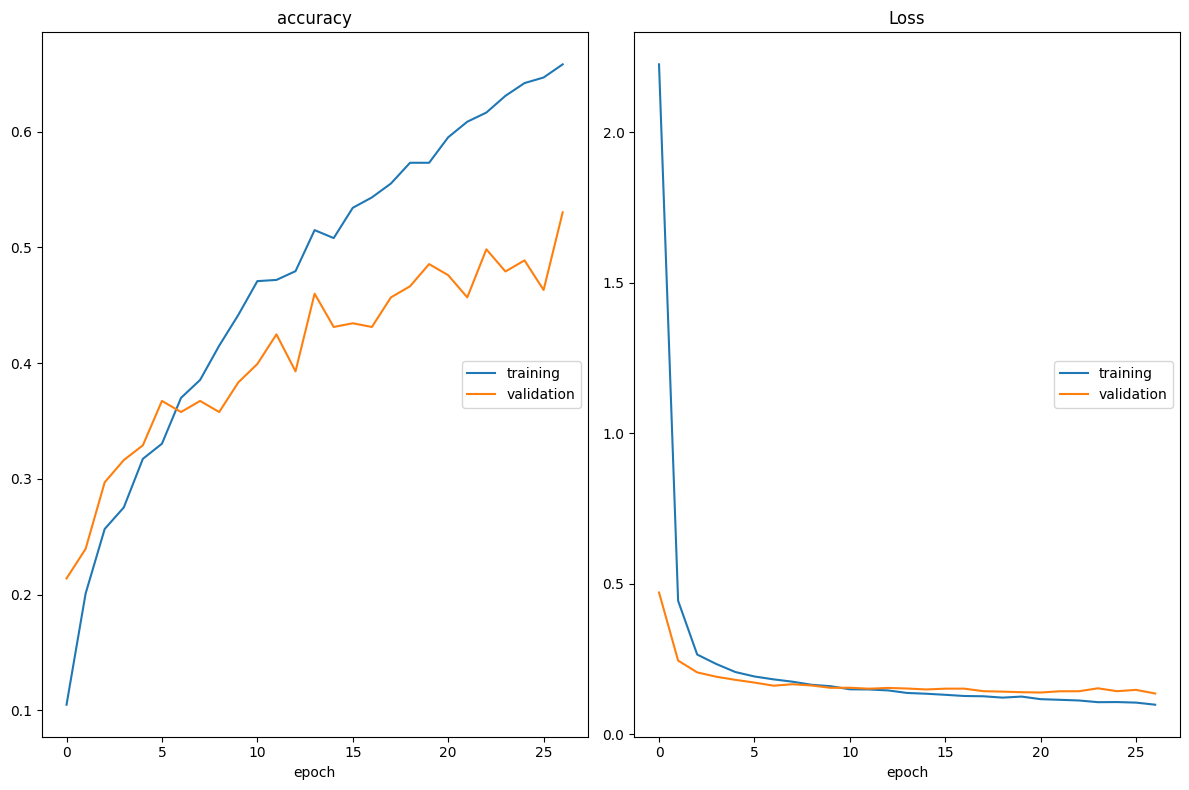

accuracy
	training         	 (min:    0.105, max:    0.658, cur:    0.658)
	validation       	 (min:    0.214, max:    0.530, cur:    0.530)
Loss
	training         	 (min:    0.098, max:    2.226, cur:    0.098)
	validation       	 (min:    0.136, max:    0.471, cur:    0.136)
46/46 [==============================] - 73s 1s/step - loss: 0.0985 - accuracy: 0.6582 - val_loss: 0.1356 - val_accuracy: 0.5304
Epoch 28/50
10/46 [=====>........................] - ETA: 10s - loss: 0.1050 - accuracy: 0.6306

KeyboardInterrupt: ignored

In [ ]:
%%time

vgg_history = vgg_model.fit(traingen,
    validation_data = validgen,
    workers=10,
    epochs=50,
                            callbacks=[tl_checkpoint_1, early_stop,plot_loss_1])

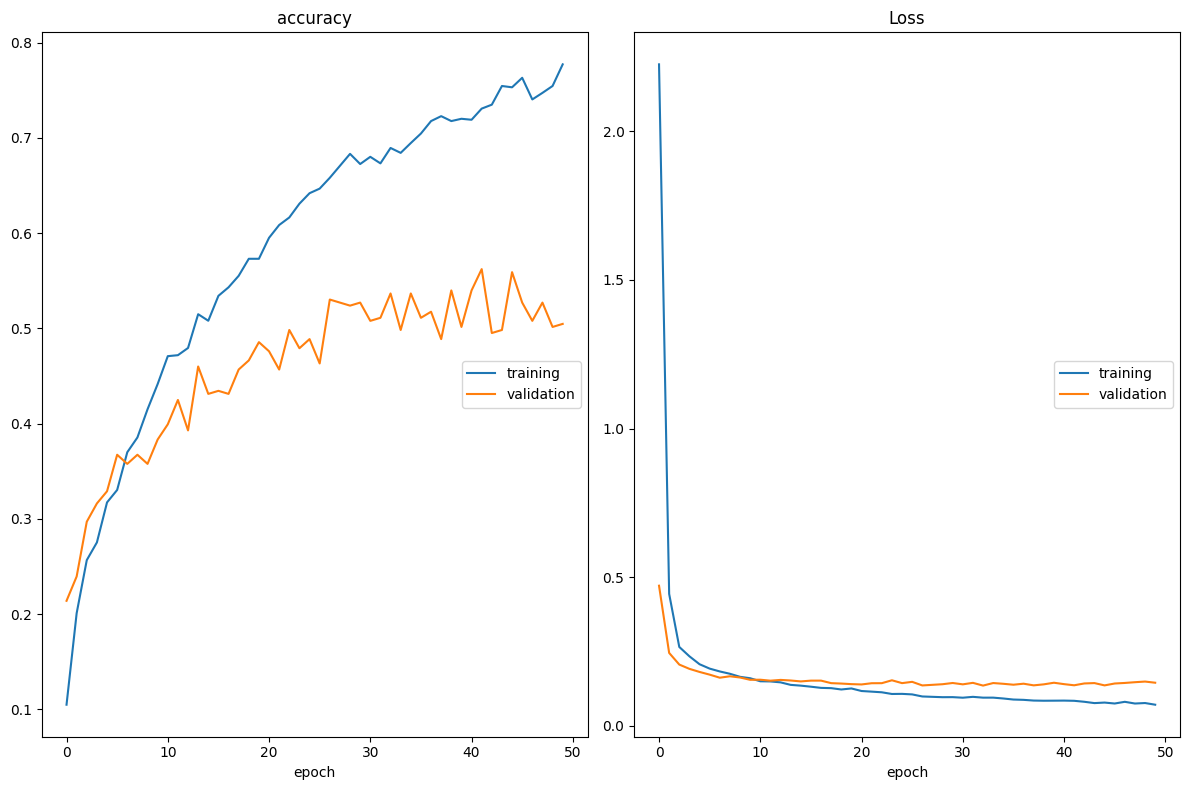

accuracy
	training         	 (min:    0.105, max:    0.777, cur:    0.777)
	validation       	 (min:    0.214, max:    0.562, cur:    0.505)
Loss
	training         	 (min:    0.071, max:    2.226, cur:    0.071)
	validation       	 (min:    0.135, max:    0.471, cur:    0.145)
46/46 [==============================] - 66s 1s/step - loss: 0.0708 - accuracy: 0.7773 - val_loss: 0.1447 - val_accuracy: 0.5048


In [ ]:
vgg_history = vgg_model.fit(traingen,
    validation_data = validgen,
    workers=10,
    epochs=50,
                            initial_epoch=35,
                            callbacks=[tl_checkpoint_1, early_stop,plot_loss_1])

In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

813/813 [==============================] - 8s 10ms/step


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 54.86%


with fine tuning

In [40]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=3)

In [41]:
vgg_model_ft.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [35]:
2359808+25691136 +102500+818

28154262

In [42]:
tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v2.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

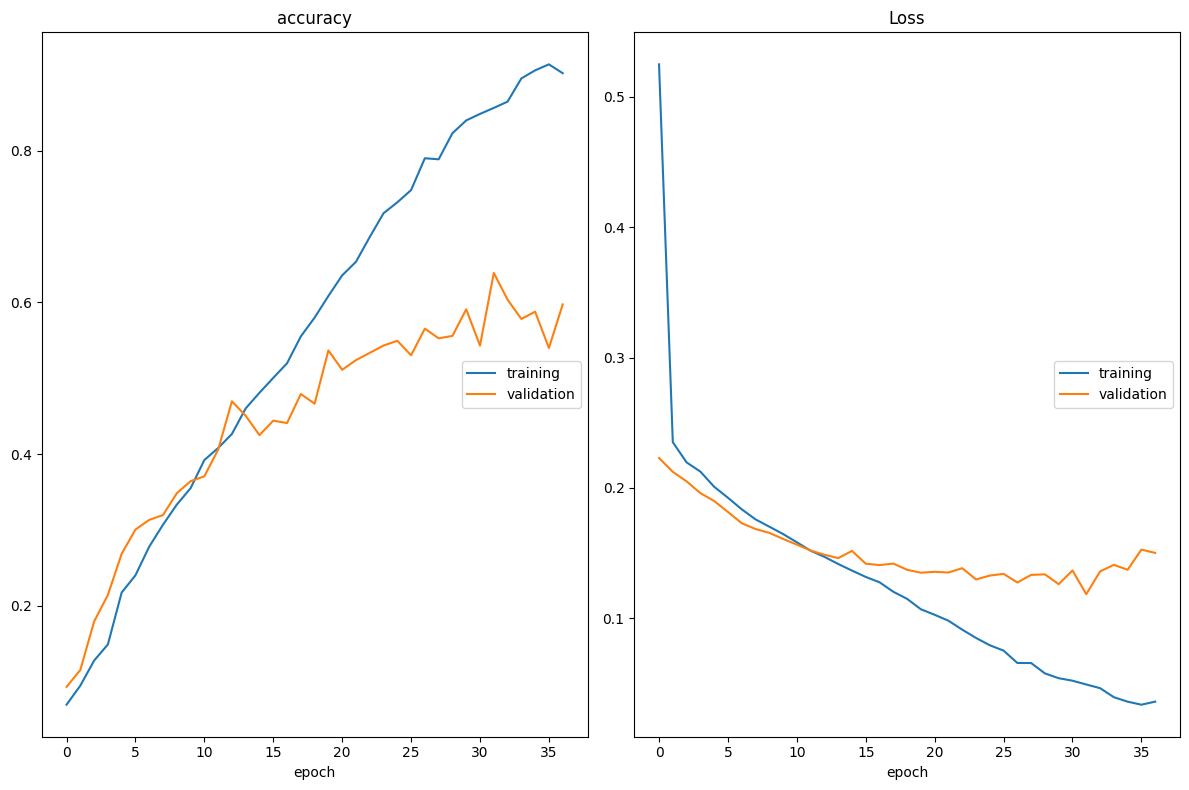

accuracy
	training         	 (min:    0.069, max:    0.914, cur:    0.903)
	validation       	 (min:    0.093, max:    0.639, cur:    0.597)
Loss
	training         	 (min:    0.034, max:    0.525, cur:    0.036)
	validation       	 (min:    0.118, max:    0.223, cur:    0.150)
46/46 [==============================] - 61s 1s/step - loss: 0.0360 - accuracy: 0.9026 - val_loss: 0.1501 - val_accuracy: 0.5974
Epoch 38/50
16/46 [=========>....................] - ETA: 27s - loss: 0.0302 - accuracy: 0.9259

KeyboardInterrupt: ignored

In [43]:
%%time
plot_loss_2 = PlotLossesCallback()

vgg_history_ft = vgg_model_ft.fit(traingen,
    validation_data = validgen,
    workers=10,
    epochs=50,
                            callbacks=[tl_checkpoint_2, early_stop,plot_loss_2])

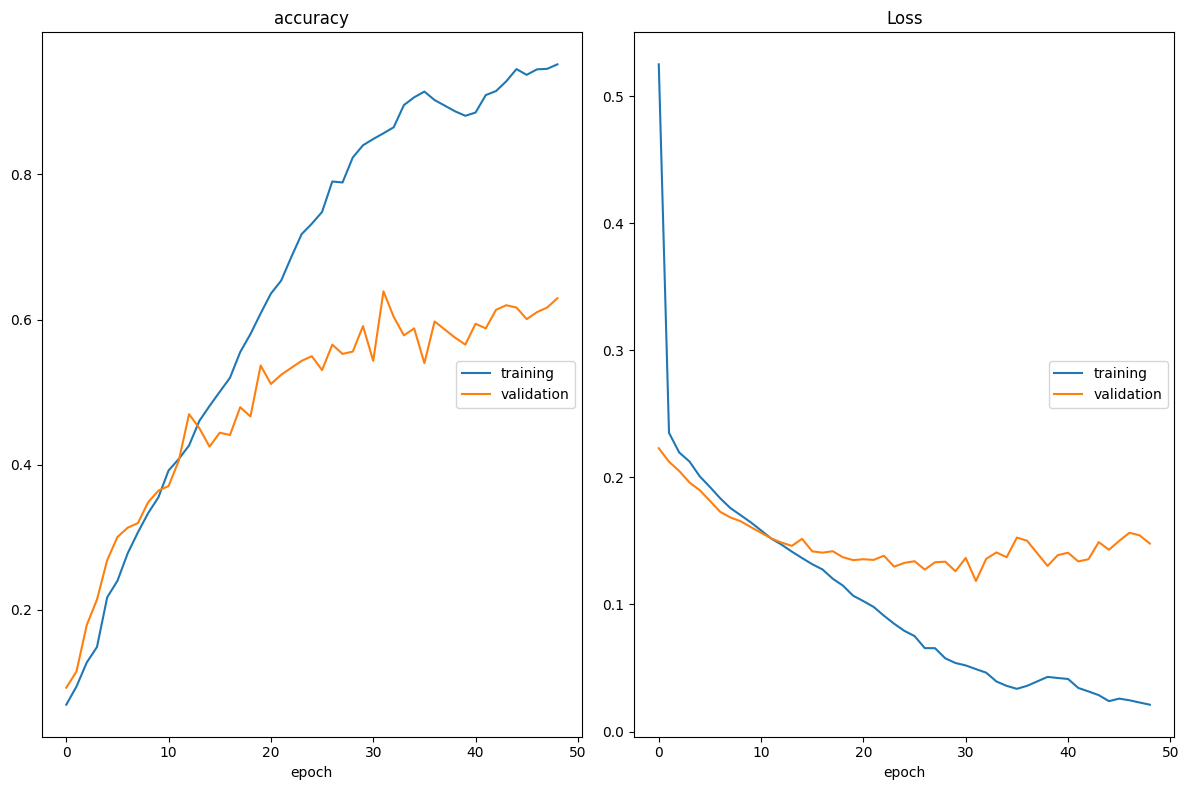

accuracy
	training         	 (min:    0.069, max:    0.952, cur:    0.952)
	validation       	 (min:    0.093, max:    0.639, cur:    0.629)
Loss
	training         	 (min:    0.021, max:    0.525, cur:    0.021)
	validation       	 (min:    0.118, max:    0.223, cur:    0.148)
46/46 [==============================] - 62s 1s/step - loss: 0.0211 - accuracy: 0.9518 - val_loss: 0.1479 - val_accuracy: 0.6294


In [51]:
vgg_history_ft = vgg_model_ft.fit(traingen,
    validation_data = validgen,
    workers=10,
    epochs=50,
                                  initial_epoch=38,
                            callbacks=[tl_checkpoint_2, early_stop,plot_loss_2])

In [52]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v2.weights.best.hdf5') # initialize the best trained weights
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())


vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)
from sklearn.metrics import accuracy_score

813/813 [==============================] - 8s 10ms/step


In [53]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 58.55%


In [54]:
import matplotlib.pyplot as plt

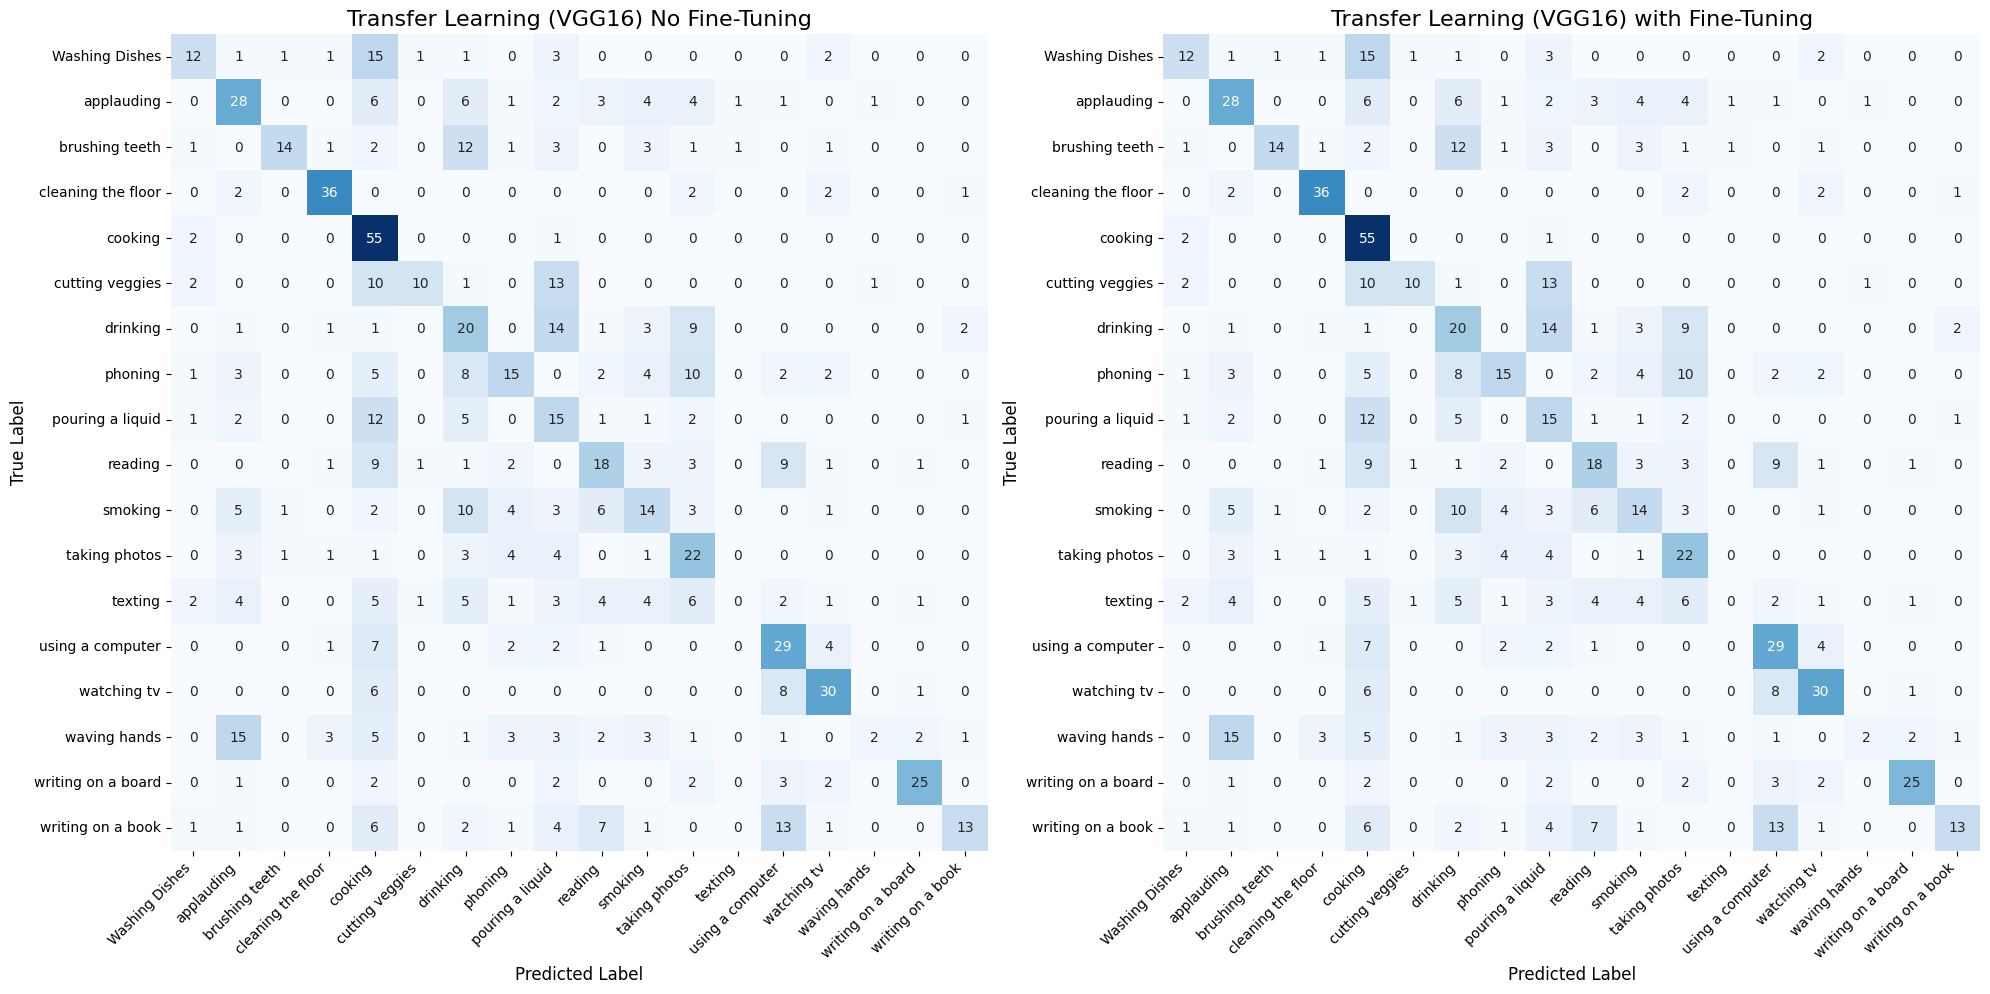

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16) No Fine-Tuning")
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax2, title="Transfer Learning (VGG16) with Fine-Tuning")

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

with channel attention module


In [28]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape

In [48]:
def create_model_1(input_shape, n_classes, optimizer='rmsprop', fine_tune = 0 ):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

  #cB


    # Add a channel attention module
    gap = GlobalAveragePooling2D()(conv_base.output)
    fc= Dense(256, activation='relu')(gap)
    #reshape = Reshape((1, 1, conv_base.output_shape[-1]))(gap)
    #fc1 = Dense(conv_base.output_shape[-1] // 8, activation='relu')(reshape)
    fc2 = Dense(conv_base.output_shape[-1], activation='sigmoid')(fc)
    attention = Multiply()([conv_base.output, fc2])

    # Add a global pooling layer
    global_pooling = GlobalAveragePooling2D()(attention)

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = Flatten(name="flatten")(global_pooling)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(100, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [38]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=18

n_steps = traingen.samples // 64
n_val_steps = validgen.samples // 64
n_epochs = 50
fine_tune = 0

In [51]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_3 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_cab = create_model_1(input_shape, n_classes, optim_3, fine_tune=3)

In [52]:
vgg_model_cab.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [53]:
tl_checkpoint_3 = ModelCheckpoint(filepath='tl_model_v3.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

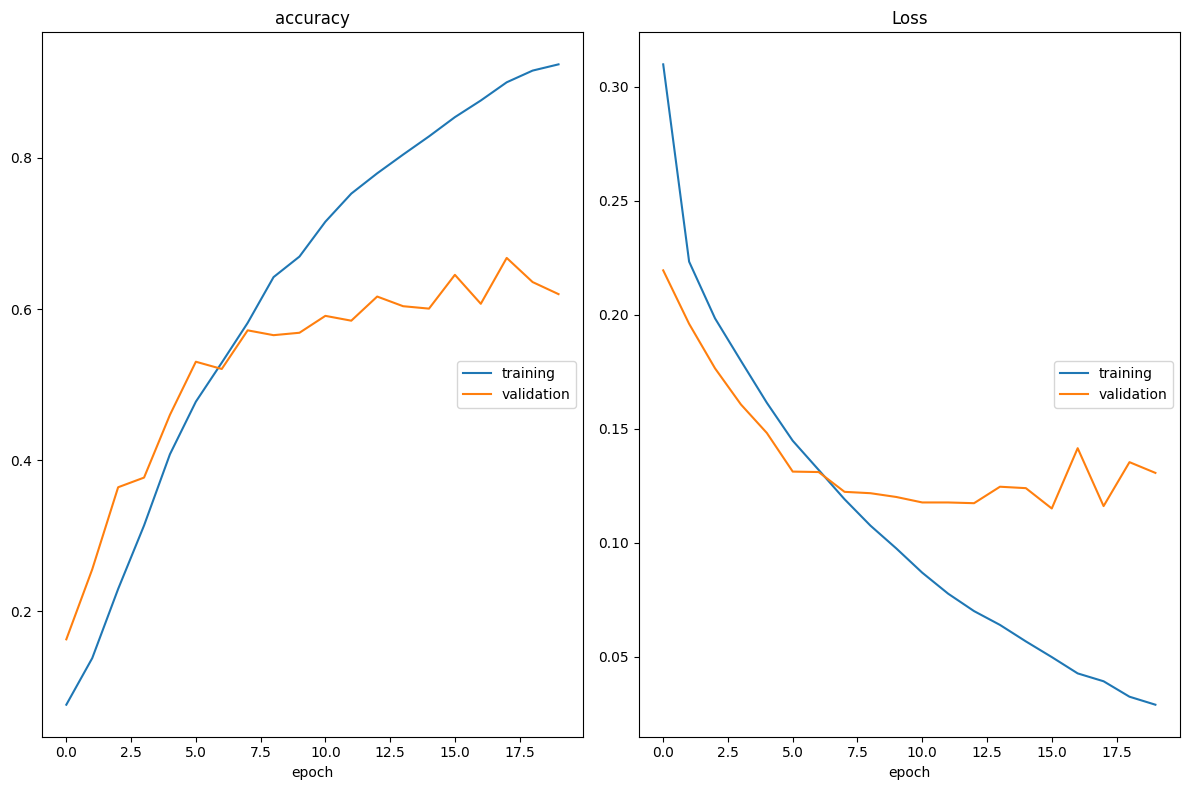

accuracy
	training         	 (min:    0.076, max:    0.924, cur:    0.924)
	validation       	 (min:    0.163, max:    0.668, cur:    0.620)
Loss
	training         	 (min:    0.029, max:    0.310, cur:    0.029)
	validation       	 (min:    0.115, max:    0.219, cur:    0.131)
46/46 [==============================] - 63s 1s/step - loss: 0.0289 - accuracy: 0.9239 - val_loss: 0.1306 - val_accuracy: 0.6198
Epoch 21/50


KeyboardInterrupt: ignored

In [54]:
%%time
plot_loss_3 = PlotLossesCallback()

vgg_history_cab = vgg_model_cab.fit(traingen,
    validation_data = validgen,
    workers=10,
    epochs=50,
                            callbacks=[tl_checkpoint_3, early_stop,plot_loss_3])

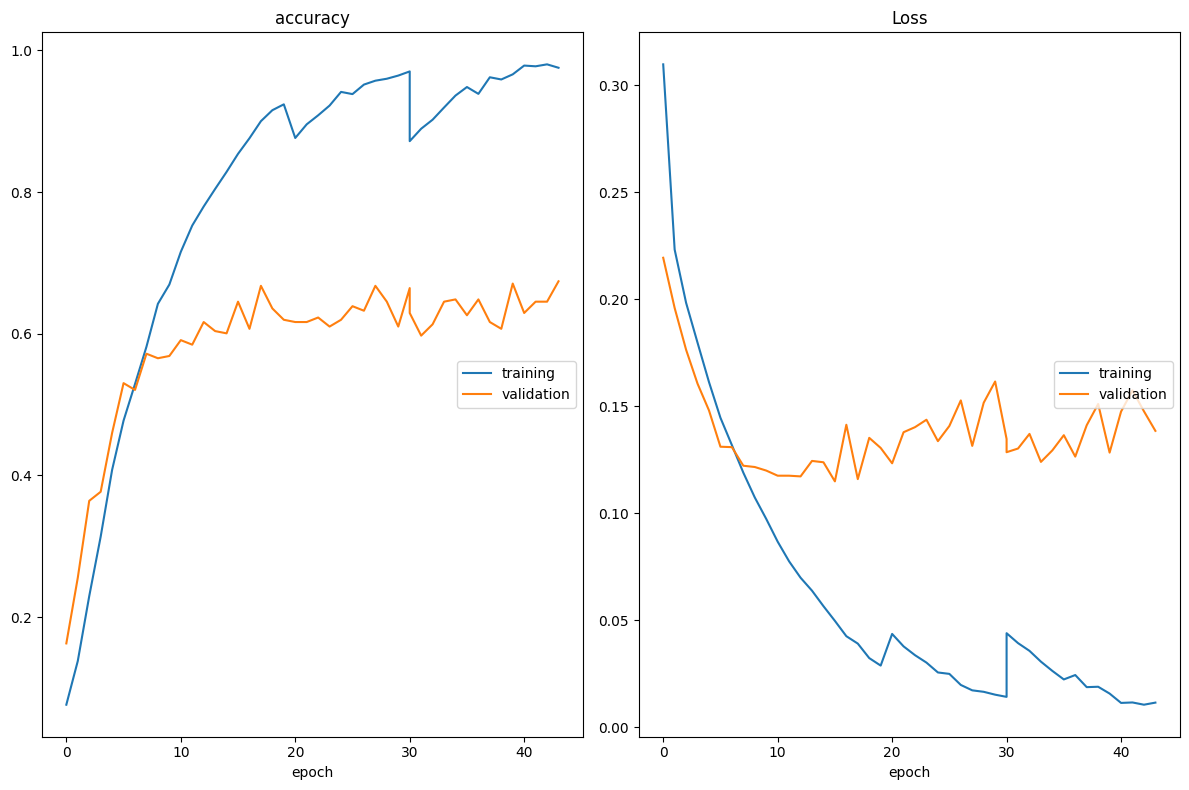

accuracy
	training         	 (min:    0.076, max:    0.980, cur:    0.976)
	validation       	 (min:    0.163, max:    0.674, cur:    0.674)
Loss
	training         	 (min:    0.011, max:    0.310, cur:    0.012)
	validation       	 (min:    0.115, max:    0.219, cur:    0.139)
46/46 [==============================] - 57s 1s/step - loss: 0.0116 - accuracy: 0.9756 - val_loss: 0.1385 - val_accuracy: 0.6741


In [62]:
vgg_history_cab = vgg_model_cab.fit(traingen,
    validation_data = validgen,
    workers=10,
    epochs=50,
                                    initial_epoch = 30,
                            callbacks=[tl_checkpoint_3, early_stop,plot_loss_3])

In [63]:
# Generate predictions
vgg_model_cab.load_weights('tl_model_v3.weights.best.hdf5') # initialize the best trained weights
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())


vgg_preds_CAB = vgg_model_cab.predict(testgen)
vgg_pred_classes_CAB = np.argmax(vgg_preds_CAB, axis=1)
from sklearn.metrics import accuracy_score

813/813 [==============================] - 8s 10ms/step


In [65]:
vgg_acc_CAB = accuracy_score(true_classes, vgg_pred_classes_CAB)
print("VGG16 Model Accuracy with Fine-Tuning + CAM: {:.2f}%".format(vgg_acc_CAB * 100))

VGG16 Model Accuracy with Fine-Tuning + CAM: 65.81%
